## Baseline Model (Non-Machine Learning) Binary Logistic Model 
The chosen baseline model for this study is Logis- tic Regression. This statistical method is ideally suited to analyse the linear relationship between the input variables (features) and the log-odds of the output variable (target). The application of the logistic model, as used in this research, mirrors the precedent set in a prior study that focused on geographic and socio-demographic characteristics related to the prevalence of food insecurity

### Imbalance in the Weights of Food Insecurity Levels 
The challenge of imbalance in the sample had to be addressed, due to the unequal representation of food insecure (FI) and non-FI households. When building a predictive model with an imbalanced class dataset, there is a propensity for the model to disproportionately weight the dominant class. This skew can lead to a reduced predictive accuracy for the less frequently represented class. It is important to note that our predictors are of various types, including numerical, categorical, and ordinal. Therefore, we employ the Synthetic Minority Over-Sampling Technique for Nominal and Continuous (SMOTE-NC) in the process of splitting. 


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc, 
    roc_auc_score, 
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import miceforest as mf
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data that is alaready imputed
new_dataset_efmjieh1 = pd.read_csv("imputedfi.csv")
# Specify the variables to scale, here we treat cardinal variable as numercial as well.
numerical_variables = ["efalimo", "efalip", "efcapgn", "efccar", "efchtxb", 
"efcpqpp", "efearng", "efgi", "efgstxc", "efgtr", "efinva", "efoasgi", "efogovtr", "efothinc", "efpen", "efpenrec", "efphpr", "efpvtxc", "efrppc", "efrspwi", "efsapis", "efsemp", 
"efsize", "efuiben", "efwkrcp", "efagofmp", "efagyfmp", "hlev2g"]

# Specify categorical variables
categorical_variables = ["eftyp", "prov", "dwltyp", "dwtenr", "marstp", "efmjsi","sex","immst","uszgap"]
new_dataset_efmjieh1.loc[new_dataset_efmjieh1['fschhldm'] >= 1, 'fschhldm'] = 1

In [3]:
# Convert target variable to categorical
new_dataset_efmjieh1['fschhldm'] = new_dataset_efmjieh1['fschhldm'].astype('category')

# Create the target and features
y = new_dataset_efmjieh1['fschhldm']
X = new_dataset_efmjieh1.drop(columns=['fschhldm'])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Create transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

# Use ColumnTransformer to apply the transformations to the correct columns in the dataframe.
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_variables),
                                               ('cat', categorical_transformer, categorical_variables)])

# Define SMOTENC for balancing the data
smote_nc = SMOTENC(categorical_features=[X_train.columns.get_loc(c) for c in categorical_variables], random_state=42)

# Instantiate the classifier
classifier = LogisticRegression(solver='saga', multi_class='ovr', max_iter=10000)

# Define the pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('smote_nc', smote_nc),
                        ('classifier', classifier)])

In [4]:
# Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['efalimo', 'efalip',
                                                   'efcapgn', 'efccar',
                                                   'efchtxb', 'efcpqpp',
                                                   'efearng', 'efgi', 'efgstxc',
                                                   'efgtr', 'efinva', 'efoasgi',
                                                   'efogovtr', 'efothinc',
                                                   'efpen', 'efpenrec',
                                                   'efphpr', 'efpvtxc',
                                                   'efrppc', 'efrspwi',
                                                   'efsapis', 'efsemp',
                                                   'efsize', 'efuiben',
                                                   'efwkrcp', 'efagofmp',
                                                   'efagyfmp', 'hlev2g']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['eftyp', 'prov', 'dwltyp',
                                                   'dwtenr', 'marstp', 'efmjsi',
                                                   'sex', 'immst',
                                                   'uszgap'])])),
                ('smote_nc',
                 SMOTENC(categorical_features=[32, 28, 29, 30, 31, 13, 34, 35,
                                               36],
                         random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=10000, multi_class='ovr',
                                    solver='saga'))])

              precision    recall  f1-score   support

           0       0.93      0.70      0.79     26545
           1       0.32      0.72      0.44      5282

    accuracy                           0.70     31827
   macro avg       0.62      0.71      0.62     31827
weighted avg       0.83      0.70      0.74     31827

              precision    recall  f1-score   support

           0       0.92      0.70      0.79      8849
           1       0.32      0.71      0.44      1761

    accuracy                           0.70     10610
   macro avg       0.62      0.70      0.62     10610
weighted avg       0.82      0.70      0.74     10610



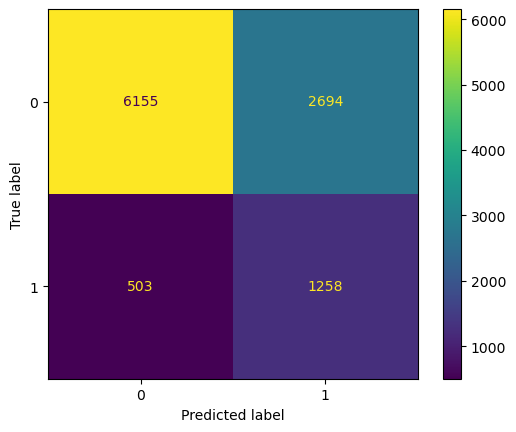

In [5]:
# Make predictions
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

# Print classification report
print(classification_report(y_train, y_hat_train))
print(classification_report(y_test, y_hat_test))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_hat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 
plt.show()

# ROC/AUC - calculate the probability of each class
y_train_bin = LabelBinarizer().fit_transform(y_train)
y_test_bin = LabelBinarizer().fit_transform(y_test)
y_hat_train_bin = model.predict_proba(X_train)
y_hat_test_bin = model.predict_proba(X_test)


In [6]:
# Compute training and test accuracy
train_acc = accuracy_score(y_train, y_hat_train)
test_acc = accuracy_score(y_test, y_hat_test)

print("Training Accuracy: {:.2f}%".format(train_acc * 100))
print("Test Accuracy: {:.2f}%".format(test_acc * 100))
# Compute probabilities
y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC AUC
roc_auc_train = roc_auc_score(y_train, y_train_proba)
roc_auc_test = roc_auc_score(y_test, y_test_proba)

print("Training ROC AUC: {:.2f}".format(roc_auc_train))
print("Test ROC AUC: {:.2f}".format(roc_auc_test))

Training Accuracy: 70.00%
Test Accuracy: 69.87%
Training ROC AUC: 0.78
Test ROC AUC: 0.78
